In [1]:

import warnings

warnings.filterwarnings('ignore')



### Read COMPAS data


In [2]:

import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('compas-scores-two-years.csv', index_col='id')
df = df.reset_index(drop=True)


In [3]:

len(df)


7214

In [4]:

df.head()


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:

df['age_cat'].value_counts()


25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64

In [6]:

df = df[['first', 'last', 'sex', 'age_cat', 'race']]


In [7]:

df.head()


,first,last,sex,age_cat,race
0,miguel,hernandez,Male,Greater than 45,Other
1,kevon,dixon,Male,25 - 45,African-American
2,ed,philo,Male,Less than 25,African-American
3,marcu,brown,Male,Less than 25,African-American
4,bouthy,pierrelouis,Male,25 - 45,Other



### Install the Bias Detector


In [8]:

%%capture

pip install --upgrade bias-detector


In [9]:

from bias_detector.BiasDetector import BiasDetector

bias_detector = BiasDetector(country='US')


In [10]:

age_cat_p_groups_correlations = dict()

for name, age_group in df.groupby('age_cat'):
    age_group = age_group.reset_index(drop=True)
    p_groups = bias_detector.get_p_groups(first_names=age_group['first'], last_names=age_group['last'])
    true_groups = pd.DataFrame(index=list(range(len(age_group))))
    true_groups['male'] = age_group['sex'] == 'Male'
    true_groups['female'] = age_group['sex'] == 'Female'
    true_groups['white'] = age_group['race'] == 'Caucasian'
    true_groups['black'] = age_group['race'] == 'African-American'
    true_groups['api'] = age_group['race'] == 'Asian'
    true_groups['hispanic'] = age_group['race'] == 'Hispanic'
    true_groups['native'] = age_group['race'] == 'Native American'
    true_groups = true_groups.fillna(0)
    true_groups = true_groups.astype(float)
    age_cat_p_groups_correlations[name] = p_groups.corrwith(true_groups)


In [11]:

%%capture

!pip install --upgrade seaborn


In [12]:

import seaborn as sns

correlations = pd.DataFrame()

for group in ['male', 'female', 'white', 'black', 'api', 'hispanic', 'native']:
    for age_cat in ['Greater than 45', '25 - 45', 'Less than 25']:
        correlations.at[age_cat, group] = age_cat_p_groups_correlations[age_cat][group]
    

In [13]:

correlations


,male,female,white,black,api,hispanic,native
Greater than 45,0.655926,0.822859,0.437532,0.572890,0.452464,0.671431,0.470523
25 - 45,0.566271,0.720013,0.285577,0.505730,0.335027,0.598389,0.536107
Less than 25,0.492214,0.622090,0.172952,0.458835,0.227523,0.543765,0.018113


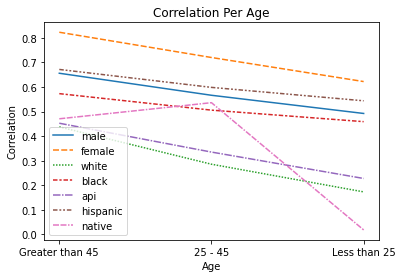

In [14]:

import matplotlib.pyplot as plt

ax = sns.lineplot(data=correlations)
ax.set(title='Correlation Per Age', xlabel='Age', ylabel='Correlation')
plt.show()
